In [1]:
################################################## Terms to consider ################################################################
# * Prepping dataset for regression
#   * Adhere to assumptions
#   * Check if the p-values associated with the predictor-response is statistically significant for the
#     variables you want to include
#   * We normally adhere to the additive assumption- 
#     The additive assumption means the effect of changes in a predictor on a response is independent
#     of the effect(s) of changes in other predictor(s)
#     * However, we can include interactions, where the relationship of two predictor variables together are
#       more significant on the response compared to the predictor variables used individually
#       * The hierarchical principle states that if we include an interaction in a model, we
#         should also include the main effects, even if the p-values associated with
#         their coefficients are not significant.
#   * Non-linear relationships can also be modeled with extensions to the normal process using polynomial regression
#     * A simple approach for incorporating non-linear associations in a linear model is to
#       include transformed versions of the predictors, for example, if the plotted shape of the responses
#       takes on a quadratic shape, a model where some of the predictor variables are squared may provide a
#       better fit
#   * Outliers in response variable found in scatter plot or residuals
#     * Outliers can have little effect on a least squares fit if it has low leverage
#     * Studentized residual plots can better show outlier points compared to the rest of the data
#   * High leverage points from predictor variables (this can impact more than outliers)
#     * To quantify the leverage when there are multiple predictors, we can compute the leverage statistic
#   * Error terms must be uncorrelated (residual data points frequently appear close to each other)
#   * Data should be linear (trends in residual data points suggest non-linearity, this could be more time series related)
#     * If the residual plot indicates that there are non-linear associations in the
#       data, then a simple approach is to use non-linear transformations of the
#       predictors, such as log X, √X, and X^2 , in the regression model
#   * Need constant variance of error terms (we don't want residuals points to increase in a trend, 
#     avoid points taking on a funnel shape)
#   * Collinearity will cause the standard error to grow, so we want to avoid variables that are highly
#     correlated with each other
#     * Can measure collinearity with a correlation matrix or with Variance Inflation Factor (VIF) for
#       multicollinearity. If there are problematic predictors, you should remove one of them and
#       re-measure. OR we can combine the predictors into one
#######################################################################################################################################

In [22]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [31]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

In [32]:
weekly.shape

(32400, 39)

In [18]:
weekly[(weekly["roof"] != "outdoors") & (weekly["roof"] != "open")]

,player_id,player_name,position,recent_team,season,week,carries,rushing_yards,rushing_tds,rushing_fumbles,...,redzone,total_usage,fantasy_points,fantasy_points_ppr,roof,surface,weather_hazards,temp,humidity,wind_speed
0,00-0020337,None,WR,BAL,2016,1,0,0.0,0,0.0,...,1.0,8,1.9,6.9,None,None,None,NaN,NaN,NaN
1,00-0020337,None,WR,BAL,2016,2,0,0.0,0,0.0,...,NaN,6,6.4,9.4,None,None,None,NaN,NaN,NaN
2,00-0020337,None,WR,BAL,2016,3,0,0.0,0,0.0,...,NaN,11,8.7,16.7,None,None,None,NaN,NaN,NaN
3,00-0020337,None,WR,BAL,2016,4,0,0.0,0,0.0,...,2.0,11,17.1,25.1,None,None,None,NaN,NaN,NaN
4,00-0020337,None,WR,BAL,2016,5,0,0.0,0,0.0,...,NaN,3,2.9,5.9,None,None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32385,00-0038134,K.Walker,RB,SEA,2022,5,8,88.0,1,0.0,...,1.0,8,14.8,14.8,dome,sportturf,NONE,71.0,0.37,7.0
32387,00-0038134,K.Walker,RB,SEA,2022,7,23,167.0,2,0.0,...,6.0,23,28.7,28.7,dome,matrixturf,NONE,73.0,0.45,5.0
32392,00-0038134,K.Walker,RB,SEA,2022,13,3,36.0,0,0.0,...,1.0,4,3.6,3.6,dome,matrixturf,NONE,64.0,0.75,2.0
32398,00-0038147,D.Baldwin,WR,CLE,2022,15,0,0.0,0,0.0,...,NaN,2,2.5,4.5,None,None,None,NaN,NaN,NaN


In [35]:
weekly[weekly["offense_snaps"].isna()].sample(10)

,player_id,player_name,position,recent_team,season,week,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,fantasy_points_ppr,roof,surface,weather_hazards,temp,humidity,wind_speed
9274,00-0031235,O.Beckham,WR,NYG,2016,18,0,0.0,0,0.0,0.0,0.0,NaN,4,11,28.0,0,0.0,0.0,138.0,13.0,2.0,-4.269609,0.202899,0.250000,0.299349,0.584545,NaN,NaN,NaN,11,2.8,6.8,None,None,None,NaN,NaN,NaN
9297,00-0031235,O.Beckham,WR,CLE,2019,8,0,0.0,0,0.0,0.0,0.0,NaN,5,7,52.0,0,0.0,0.0,80.0,21.0,2.0,-0.518864,0.650000,0.233333,0.334728,0.584310,NaN,NaN,NaN,7,5.2,10.2,None,None,None,NaN,NaN,NaN
12982,00-0032112,J.Nelson,WR,ARI,2016,10,0,0.0,0,0.0,0.0,0.0,NaN,2,6,29.0,0,1.0,1.0,148.0,8.0,1.0,-8.520481,0.195946,0.125000,0.282443,0.385210,NaN,NaN,NaN,6,0.9,2.9,None,None,None,NaN,NaN,NaN
28421,00-0035806,J.Hasty,RB,JAX,2022,12,12,28.0,0,0.0,0.0,1.0,-5.380816,5,5,67.0,1,0.0,0.0,23.0,44.0,3.0,7.266873,2.913044,0.135135,0.089844,0.265593,NaN,NaN,5.0,17,15.5,20.5,outdoors,grass,NONE,74.0,0.91,14.0
29871,00-0036357,H.Ruggs,WR,LV,2020,9,1,10.0,0,0.0,0.0,1.0,0.598923,0,3,0.0,0,0.0,0.0,74.0,0.0,0.0,-3.578800,0.000000,0.130435,0.263345,0.379994,NaN,NaN,NaN,4,1.0,1.0,dome,matrixturf,NONE,60.0,0.52,18.0
16564,00-0032974,J.Payton,WR,CLE,2016,6,0,0.0,0,0.0,0.0,0.0,NaN,0,2,0.0,0,0.0,0.0,34.0,0.0,0.0,-0.715682,0.000000,0.047619,0.084367,0.130486,NaN,NaN,NaN,2,0.0,0.0,None,None,None,NaN,NaN,NaN
29873,00-0036357,H.Ruggs,WR,LV,2020,11,1,12.0,0,0.0,0.0,1.0,0.640372,1,1,5.0,0,0.0,0.0,0.0,5.0,0.0,-0.001480,0.000000,0.034483,0.000000,0.051724,NaN,NaN,NaN,2,1.7,2.7,dome,grass,NONE,66.0,0.15,1.0
9326,00-0031235,O.Beckham,WR,LA,2021,17,0,0.0,0,0.0,0.0,0.0,NaN,5,7,39.0,1,0.0,0.0,74.0,4.0,2.0,1.479368,0.527027,0.200000,0.297189,0.508032,NaN,NaN,2.0,7,9.9,14.9,None,None,None,NaN,NaN,NaN
2639,00-0027918,None,WR,CLE,2016,5,0,0.0,0,0.0,0.0,0.0,NaN,4,7,56.0,1,0.0,0.0,64.0,9.0,3.0,2.167996,0.875000,0.200000,0.164103,0.414872,NaN,NaN,1.0,7,11.6,15.6,None,None,None,NaN,NaN,NaN
18342,00-0033296,A.Armah,RB,CAR,2020,17,0,0.0,0,0.0,0.0,0.0,NaN,0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.592788,0.000000,0.027778,0.000000,0.041667,NaN,NaN,NaN,1,0.0,0.0,None,None,None,NaN,NaN,NaN


In [33]:
weekly.isna().sum()

player_id                          0
player_name                      315
position                           0
recent_team                        0
season                             0
week                               0
carries                            0
rushing_yards                      0
rushing_tds                        0
rushing_fumbles                    0
rushing_fumbles_lost               0
rushing_first_downs                0
rushing_epa                    21058
receptions                         0
targets                            0
receiving_yards                    0
receiving_tds                      0
receiving_fumbles                  0
receiving_fumbles_lost             0
receiving_air_yards                0
receiving_yards_after_catch        0
receiving_first_downs              0
receiving_epa                   2305
racr                            2305
target_share                    2305
air_yards_share                 2305
wopr                            2305
o

In [45]:
# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]

In [23]:
weekly1.head()

,player_id,player_name,position,recent_team,season,week,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,efficiency,percent_attempts_gte_eight_defenders,avg_time_to_los,rush_yards_over_expected,avg_rush_yards,rush_yards_over_expected_per_att,rush_pct_over_expected,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,fantasy_points_ppr,roof,surface,weather_hazards,temp,humidity,wind_speed
14,00-0021547,A.Gates,TE,LAC,2016,1,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4,20.0,0,0.0,0.0,19.0,9.0,0.0,-0.258469,1.052632,0.111111,0.087156,0.227676,48.0,0.66,NaN,4,2.0,5.0,None,None,None,NaN,NaN,NaN
15,00-0021547,A.Gates,TE,LAC,2016,2,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5,15.0,1,0.0,0.0,25.0,8.0,2.0,0.662646,0.600000,0.200000,0.122549,0.385784,36.0,0.53,3.0,5,7.5,10.5,None,None,None,NaN,NaN,NaN
16,00-0021547,A.Gates,TE,LAC,2016,5,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5,30.0,1,1.0,1.0,36.0,6.0,2.0,-0.809390,0.833333,0.166667,0.076596,0.303617,18.0,0.35,1.0,5,7.0,11.0,None,None,None,NaN,NaN,NaN
17,00-0021547,A.Gates,TE,LAC,2016,6,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,16.0,0,0.0,0.0,52.0,4.0,2.0,-0.385813,0.307692,0.206897,0.256158,0.489655,31.0,0.47,NaN,6,1.6,3.6,None,None,None,NaN,NaN,NaN
18,00-0021547,A.Gates,TE,LAC,2016,7,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,10,38.0,0,0.0,0.0,77.0,13.0,3.0,1.970081,0.493507,0.227273,0.198454,0.479827,38.0,0.51,3.0,10,3.8,8.8,None,None,None,NaN,NaN,NaN


In [46]:

weekly1.isna().sum()

player_id                      0
player_name                    0
position                       0
recent_team                    0
season                         0
week                           0
carries                        0
rushing_yards                  0
rushing_tds                    0
rushing_fumbles                0
rushing_fumbles_lost           0
rushing_first_downs            0
rushing_epa                    0
receptions                     0
targets                        0
receiving_yards                0
receiving_tds                  0
receiving_fumbles              0
receiving_fumbles_lost         0
receiving_air_yards            0
receiving_yards_after_catch    0
receiving_first_downs          0
receiving_epa                  0
racr                           0
target_share                   0
air_yards_share                0
wopr                           0
offense_snaps                  0
offense_pct                    0
redzone                        0
total_usag

In [55]:
weekly1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30952 entries, 14 to 32398
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    30952 non-null  object 
 1   player_name                  30952 non-null  object 
 2   position                     30952 non-null  object 
 3   recent_team                  30952 non-null  object 
 4   season                       30952 non-null  int64  
 5   week                         30952 non-null  int64  
 6   carries                      30952 non-null  int64  
 7   rushing_yards                30952 non-null  float64
 8   rushing_tds                  30952 non-null  int64  
 9   rushing_fumbles              30952 non-null  float64
 10  rushing_fumbles_lost         30952 non-null  float64
 11  rushing_first_downs          30952 non-null  float64
 12  rushing_epa                  30952 non-null  float64
 13  receptions     

In [56]:
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

In [58]:
weekly2 = weekly1.select_dtypes(include="number")

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_frame_with_const = add_constant(weekly2)

In [53]:
pd.to_numeric(weekly1["player_name"], errors='coerce')

14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
         ..
32394   NaN
32395   NaN
32396   NaN
32397   NaN
32398   NaN
Name: player_name, Length: 30952, dtype: float64

In [83]:
def create_vif_table(df):
    data_frame_with_const = add_constant(df.select_dtypes(include="number"))
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame_with_const.values, i) for i in range(data_frame_with_const.shape[1])]
    return vif_data

In [70]:
# pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

vif_data

,Variable,VIF
0,const,5.00
1,carries,3122079464381.63
2,rushing_yards,53.40
3,rushing_tds,23.63
4,rushing_fumbles,2.62
5,rushing_fumbles_lost,3.36
6,rushing_first_downs,9.04
7,rushing_epa,4.87
8,receptions,187415235.18
9,targets,1071121.86


In [73]:
def correlation_heatmap(df):
    correlation_matrix = df.select_dtypes(include="number").corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    fig, ax = plt.subplots()
    fig.tight_layout()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, mask=mask)
    plt.show()

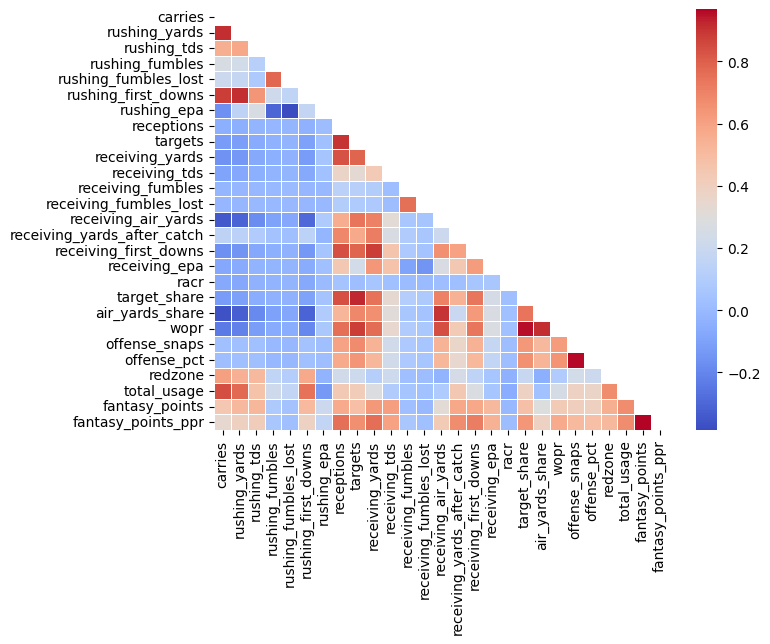

In [74]:
correlation_heatmap(weekly1)

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(weekly1.select_dtypes(include='number')), columns=weekly1.select_dtypes(include='number').columns)


In [92]:
def create_scaled_data(df):
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.select_dtypes(include='number')), columns=df.select_dtypes(include='number').columns)
    return df_scaled

In [91]:
df_scaled

,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,fantasy_points_ppr
0,-0.49,-0.45,-0.25,-0.14,-0.11,-0.43,0.11,0.16,0.01,-0.29,-0.41,-0.16,-0.12,-0.32,-0.27,-0.89,-0.30,0.06,-0.07,-0.21,-0.14,0.64,0.45,-0.65,-0.44,-0.61,-0.43
1,-0.49,-0.45,-0.25,-0.14,-0.11,-0.43,0.11,0.16,0.32,-0.45,1.86,-0.16,-0.12,-0.17,-0.33,0.36,-0.02,-0.04,0.90,0.03,0.57,0.02,-0.02,1.54,-0.28,0.29,0.28
2,-0.49,-0.45,-0.25,-0.14,-0.11,-0.43,0.11,0.59,0.32,0.02,1.86,5.85,7.93,0.10,-0.45,0.36,-0.47,0.01,0.53,-0.28,0.20,-0.92,-0.67,0.08,-0.28,0.21,0.35
3,-0.49,-0.45,-0.25,-0.14,-0.11,-0.43,0.11,-0.26,0.63,-0.41,-0.41,-0.16,-0.12,0.49,-0.57,0.36,-0.34,-0.10,0.97,0.95,1.03,-0.24,-0.24,-0.65,-0.11,-0.67,-0.61
4,-0.49,-0.45,-0.25,-0.14,-0.11,-0.43,0.11,1.02,1.87,0.27,-0.41,-0.16,-0.12,1.09,-0.03,0.98,0.39,-0.06,1.19,0.55,0.99,0.12,-0.09,1.54,0.56,-0.31,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30947,4.24,3.62,-0.25,-0.14,-0.11,3.81,-1.78,-0.26,-0.60,-0.97,-0.41,-0.16,-0.12,-0.92,-0.57,-0.89,-0.72,-0.10,-0.71,-0.97,-0.88,0.22,-0.02,0.08,3.54,0.79,0.54
30948,3.69,4.61,-0.25,-0.14,-0.11,2.40,-0.16,-0.69,-0.91,-0.63,-0.41,-0.16,-0.12,-0.80,-0.21,-0.27,0.08,-2.06,-0.89,-0.83,-0.93,0.27,0.12,3.72,2.88,1.39,0.90
30949,4.78,3.89,-0.25,-0.14,-0.11,4.52,-3.09,-0.69,-0.91,-0.60,-0.41,-0.16,-0.12,-0.80,-0.15,-0.89,-0.09,-2.27,-0.89,-0.83,-0.93,1.31,1.20,4.45,3.88,1.10,0.66
30950,2.24,1.95,2.71,-0.14,-0.11,2.40,1.21,-0.69,-0.91,-0.82,-0.41,-0.16,-0.12,-0.78,-0.63,-0.89,-0.32,-0.17,-0.96,-0.81,-0.96,0.64,0.63,1.54,1.55,1.13,0.69


In [79]:
create_vif_table(df_scaled)

,Variable,VIF
0,const,1.00
1,carries,21772008.15
2,rushing_yards,53.40
3,rushing_tds,23.63
4,rushing_fumbles,2.62
5,rushing_fumbles_lost,3.36
6,rushing_first_downs,9.04
7,rushing_epa,4.87
8,receptions,12174161201.33
9,targets,17620398.47


In [89]:
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]

exclude_columns = ["receptions", "air_yards_share", "wopr", "offense_snaps", "carries", "targets", "fantasy_points", "fantasy_points_ppr", "receiving_yards",
                   "rushing_yards"]

weekly1_after_filter = weekly1[[col for col in weekly1 if col not in exclude_columns]]

In [90]:
create_vif_table(weekly1_after_filter)

,Variable,VIF
0,const,4.98
1,rushing_tds,1.97
2,rushing_fumbles,2.62
3,rushing_fumbles_lost,2.87
4,rushing_first_downs,7.91
5,rushing_epa,2.85
6,receiving_tds,1.51
7,receiving_fumbles,2.32
8,receiving_fumbles_lost,2.38
9,receiving_air_yards,3.56


In [93]:
weekly_scaled = create_scaled_data(weekly1_after_filter)

In [204]:
weekly1_after_filter["total_epa"] = weekly1_after_filter["rushing_epa"] + weekly1_after_filter["receiving_epa"]
weekly1_after_filter["total_first_downs"] = weekly1_after_filter["rushing_first_downs"] + weekly1_after_filter["receiving_first_downs"]

In [99]:
from sklearn.linear_model import Lasso

y = weekly1[["fantasy_points_ppr"]]
X = weekly_scaled

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X, y)
selected_features = X.columns[lasso_model.coef_ != 0]

In [207]:
y = weekly1[["fantasy_points_ppr"]]
X = weekly1_after_filter.select_dtypes(include="number")

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X, y)
selected_features1 = X.columns[lasso_model.coef_ != 0]
print(selected_features1)

Index(['total_epa', 'total_first_downs', 'redzone', 'target_share', 'redzone',
       'offense_pct', 'total_usage'],
      dtype='object')


In [342]:
try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]

In [343]:
# model_data = weekly1_after_filter[selected_features]
model_data = weekly1_after_filter[try_columns]
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
14,-0.26,0.00,0.11,0.00,0.66,4
15,0.66,2.00,0.20,3.00,0.53,5
16,-0.81,2.00,0.17,1.00,0.35,5
17,-0.39,2.00,0.21,0.00,0.47,6
18,1.97,3.00,0.23,3.00,0.51,10


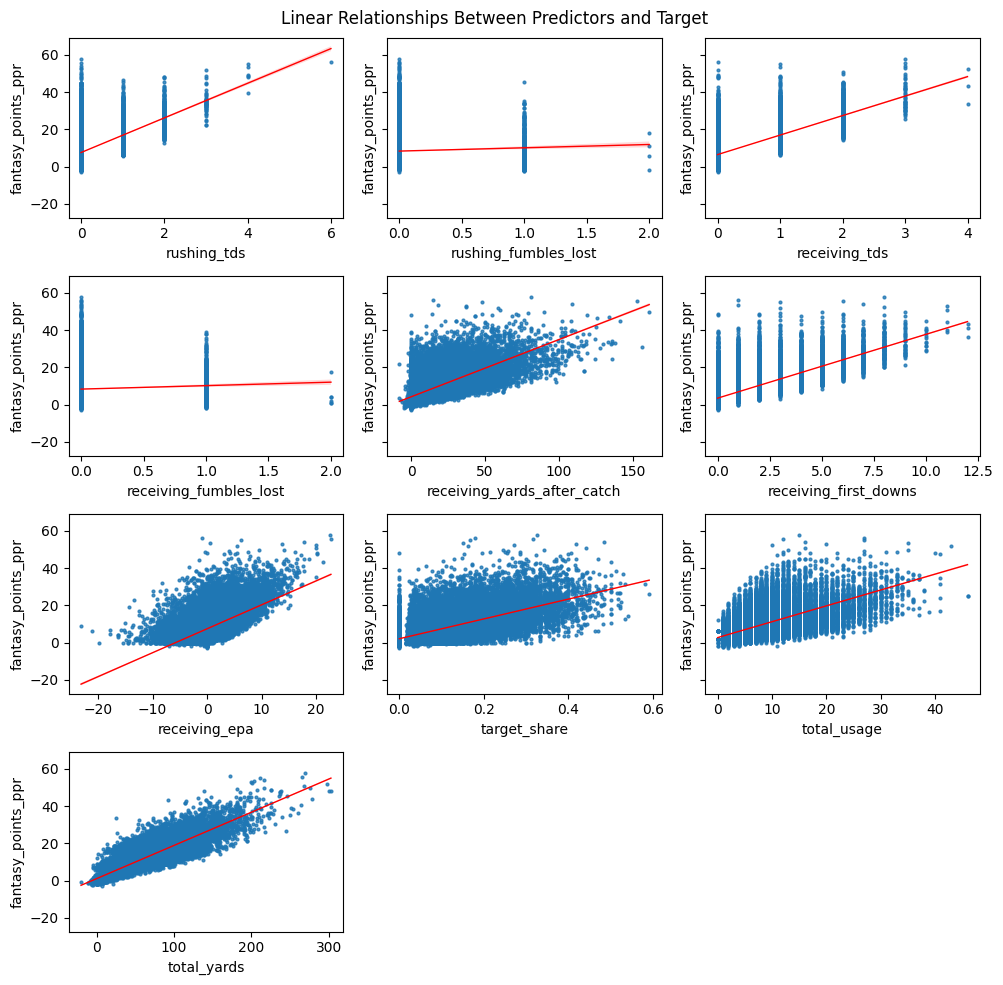

In [221]:
# With normal columns

y = weekly1[["fantasy_points_ppr"]]

ncols = int(np.floor(np.sqrt(len(selected_features))))
nrows = int(np.ceil(np.sqrt(len(selected_features))))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharey=True)
fig.suptitle("Linear Relationships Between Predictors and Target")
for i, col in enumerate(model_data.columns):
    grid_col = i % ncols
    grid_row = int(np.floor(i / ncols))
    # current_ax = ax[grid_row, grid_col]
    # x_lim = current_ax.get_xlim()
    # ax[grid_row, grid_col].set_title(col)
    scatter_style = dict(
        s = 4
    )
    line_style = dict(
        color = "red",
        linestyle = "-",
        linewidth = 1
    )
    sns.regplot(x=model_data[col], y=weekly1["fantasy_points_ppr"], ax=ax[grid_row, grid_col], scatter_kws=scatter_style, line_kws=line_style)
if len(model_data.columns) % ncols > 0:
    for i in range(1, (len(model_data.columns) % ncols) + 2):
        ax[ncols, i].remove()
plt.tight_layout()
plt.show()

In [248]:
# Fit a quadratic curve using numpy.polyfit
degree = 2  # Degree of the polynomial (quadratic in this case)
coefficients = np.polyfit(model_data["total_epa"], y, degree)

In [249]:
X1_curve = model_data["total_epa"]
y_curve = np.polyval(coefficients, X1_curve)

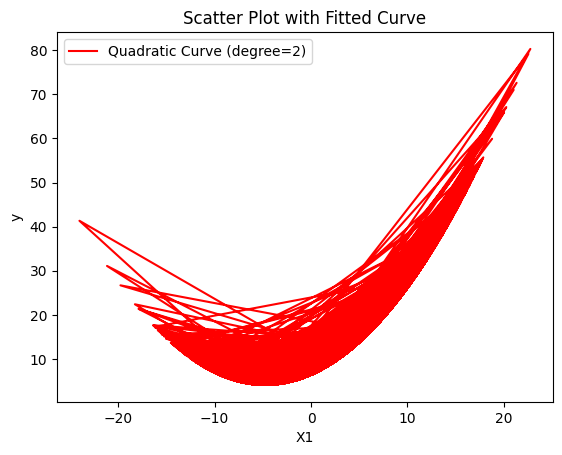

In [250]:


# Plot the fitted curve
plt.plot(X1_curve, y_curve, color='red', label=f'Quadratic Curve (degree={degree})')

plt.xlabel('X1')
plt.ylabel('y')
plt.title('Scatter Plot with Fitted Curve')
plt.legend()
plt.show()

In [284]:
int(np.sqrt(7))

2

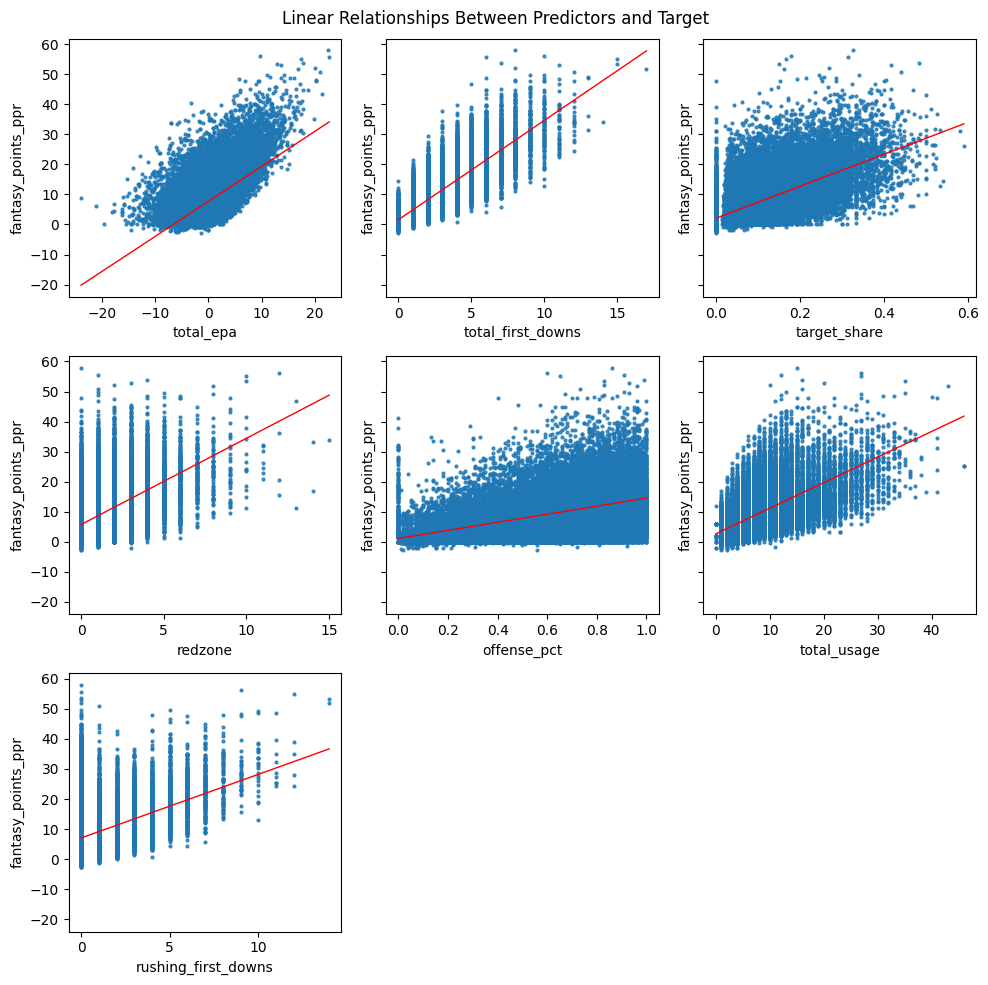

In [341]:
# With try columns

y = weekly1[["fantasy_points_ppr"]]

ncols = int(np.ceil(np.sqrt(len(try_columns))))
nrows = int(np.ceil(len(try_columns) / ncols))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10), sharey=True)
fig.suptitle("Linear Relationships Between Predictors and Target")

# Flatten the axes if nrows > 1
ax = ax.flatten()

for i, (col, ax_) in enumerate(zip(model_data.columns, ax)):
    scatter_style = dict(s=4)
    line_style = dict(color="red", linestyle="-", linewidth=1)

    sns.regplot(x=model_data[col], y=y, ax=ax_, order=1, ci=None, scatter_kws=scatter_style, line_kws=line_style)
    # ax_.set_title(col)

# Remove extra subplots
for i in range(len(model_data.columns), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

In [336]:
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
14,-0.26,0.00,0.11,0.00,0.66,4
15,0.66,2.00,0.20,3.00,0.53,5
16,-0.81,2.00,0.17,1.00,0.35,5
17,-0.39,2.00,0.21,0.00,0.47,6
18,1.97,3.00,0.23,3.00,0.51,10


In [277]:
model_data.shape
# weekly1["fantasy_points_ppr"].shape

(30952, 7)

In [368]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()

y = weekly1[["fantasy_points"]].values
X = model_data.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=17)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred

# Standardize residuals
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

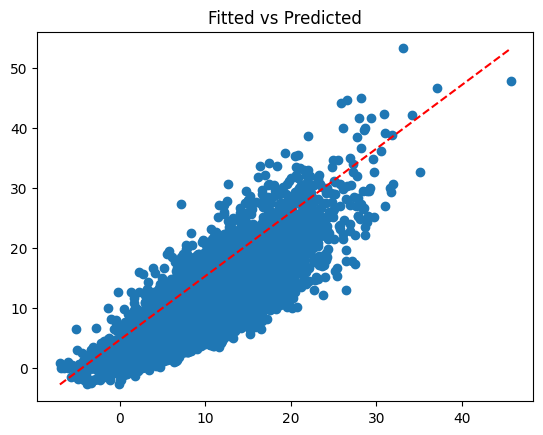

In [376]:
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Identity Line')
plt.title("Fitted vs Predicted")
plt.show()

In [362]:
weights_for_target_stats = model.coef_ / np.sum(model.coef_)
dict(zip(model_data.columns, list(weights_for_target_stats[0])))

{'total_epa': 0.07922377154254302,
 'total_first_downs': 0.08737656843751265,
 'target_share': 0.6759232686634413,
 'redzone': 0.08584639507523299,
 'offense_pct': 0.02985194070923174,
 'total_usage': 0.0417780555720384}

In [358]:
list(weights_for_target_stats[0])

[0.02883355469081992,
 0.03768409089326674,
 0.8882564308708955,
 0.024194628674620557,
 0.006810490399945057,
 0.01422080447045227]

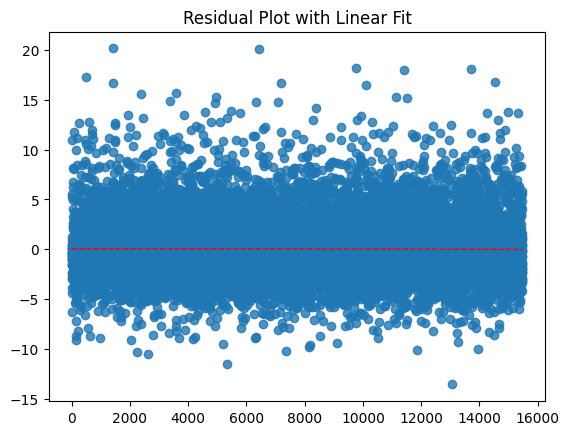

In [363]:
fig, ax = plt.subplots()
plt.title("Residual Plot with Linear Fit")
sns.regplot(x=np.arange(len(residuals)), y=residuals, line_kws={"color": "red", "linestyle": "dashed", "linewidth": 1})
plt.show()

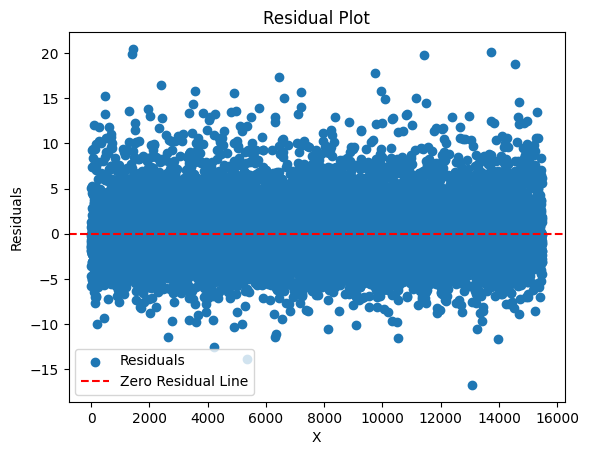

In [346]:
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')  # Add a line at y=0 for reference
plt.xlabel('X')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

In [273]:
#Transform total_epa

model_data["total_epa_transformed"] = np.sqrt(model_data["total_epa"]).fillna(0)


model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage,total_epa_transformed
14,-0.26,0.00,0.11,0.00,0.66,4,0.00
15,0.66,2.00,0.20,3.00,0.53,5,0.81
16,-0.81,2.00,0.17,1.00,0.35,5,0.00
17,-0.39,2.00,0.21,0.00,0.47,6,0.00
18,1.97,3.00,0.23,3.00,0.51,10,1.40


In [364]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# Print metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')
print(f'Explained Variance Score: {evs}')

Mean Squared Error: 8.068268178109529
R-squared: 0.7856071535722099
Mean Absolute Error: 1.9630646495782662
Explained Variance Score: 0.7856211485766558


In [197]:
model_data1 = model_data.copy()
model_data1 = model_data1.drop(["rushing_fumbles_lost", "receiving_tds", "receiving_fumbles_lost", "receiving_yards_after_catch"], axis=1)

,rushing_tds,receiving_first_downs,receiving_epa,target_share,total_usage,total_yards
14,0,0.00,-0.26,0.11,4,20.00
15,0,2.00,0.66,0.20,5,15.00
16,0,2.00,-0.81,0.17,5,30.00
17,0,2.00,-0.39,0.21,6,16.00
18,0,3.00,1.97,0.23,10,38.00
...,...,...,...,...,...,...
32394,0,0.00,-1.61,0.05,28,105.00
32395,0,1.00,0.97,0.04,24,142.00
32396,0,0.00,0.43,0.04,30,124.00
32397,1,0.00,-0.31,0.03,16,66.00


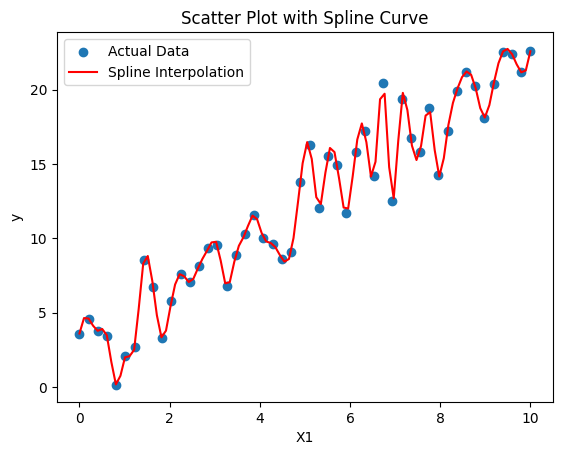

In [251]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline

# Generate sample data with multiple features
np.random.seed(42)
X1 = np.linspace(0, 10, 50).reshape(-1, 1)
X2 = np.random.rand(50, 1)
X = np.hstack((X1, X2))
y = 2 * X1.flatten() + 3 * X2.flatten() + 1 + np.random.normal(0, 2, size=len(X1))

# Sort data by X1 for smoother curve
sorted_indices = np.argsort(X1.flatten())
X1_sorted = X1[sorted_indices]
y_sorted = y[sorted_indices]

# Fit a spline interpolation
spline = UnivariateSpline(X1_sorted.flatten(), y_sorted, s=0)

# Generate values for X1 for plotting the spline curve
X1_spline = np.linspace(min(X1), max(X1), 100)

# Calculate corresponding values for y based on the spline interpolation
y_spline = spline(X1_spline)

# Plot the scatter plot
plt.scatter(X1.flatten(), y, label='Actual Data')

# Plot the spline curve
plt.plot(X1_spline, y_spline, color='red', label='Spline Interpolation')

plt.xlabel('X1')
plt.ylabel('y')
plt.title('Scatter Plot with Spline Curve')
plt.legend()
plt.show()


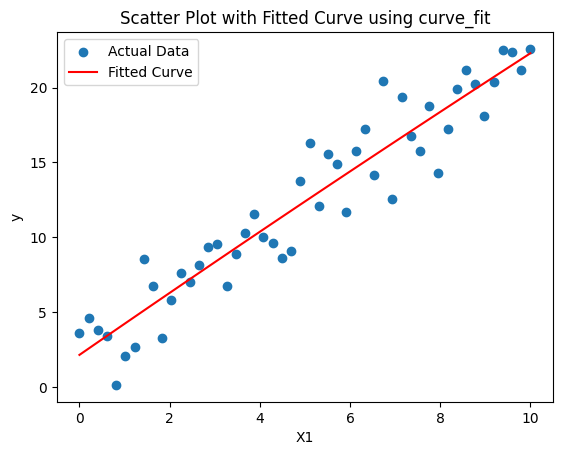

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a quadratic function
def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

# Generate sample data with multiple features
np.random.seed(42)
X1 = np.linspace(0, 10, 50)
X2 = np.random.rand(50)
X = np.hstack((X1, X2))
y = 2 * X1 + 3 * X2 + 1 + np.random.normal(0, 2, size=len(X1))

# Use curve_fit to fit the quadratic function to the data
params, covariance = curve_fit(quadratic_function, X1, y)

# Generate values for X1 for plotting the fitted curve
X1_fit = np.linspace(min(X1), max(X1), 100)

# Calculate corresponding values for y based on the fitted parameters
y_fit = quadratic_function(X1_fit, *params)

# Plot the scatter plot
plt.scatter(X1, y, label='Actual Data')

# Plot the fitted curve
plt.plot(X1_fit, y_fit, color='red', label='Fitted Curve')

plt.xlabel('X1')
plt.ylabel('y')
plt.title('Scatter Plot with Fitted Curve using curve_fit')
plt.legend()
plt.show()



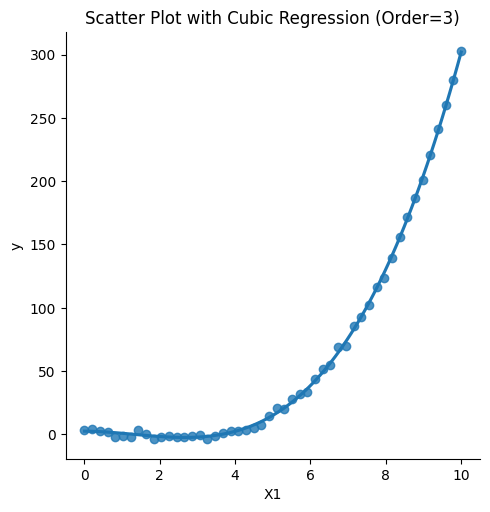

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data with multiple features
np.random.seed(42)
X1 = np.linspace(0, 10, 50)
X2 = np.random.rand(50)
X = np.hstack((X1, X2))
y = 0.5 * X1**3 - 2 * X1**2 + 3 * X2 + 1 + np.random.normal(0, 2, size=len(X1))

# Create a DataFrame for seaborn
data = {'X1': X1.flatten(), 'y': y}
df = pd.DataFrame(data)

# Plot the scatter plot with cubic regression line
sns.lmplot(x='X1', y='y', data=df, order=3, ci=None)

plt.xlabel('X1')
plt.ylabel('y')
plt.title('Scatter Plot with Cubic Regression (Order=3)')
plt.show()

In [ ]:
# Things I still want to test...
# what is the effect opposing defenses have on a players fantasy points, target share, epa, etc
# what is the same effect when weather or injuries are in play? (how many weeks out is the injured player/type of injury)
# look at rookie's first year/later year production based on their combine results and school
# what is the linear fit with other variables included in the future